In [1]:
from skimage.io import imread, imsave, imshow, imshow_collection
from skimage.color import ycbcr2rgb
import numpy as np
import skimage

from visualize import (visualize,
                       visualize_block_splitting,
                       visualize_DCT_kernel_matrix,
                       visualize_huffman_tree)
### DCT block ###
import scipy
from math import cos, floor, pi, sqrt

### Huffman Tree block###
import heapq
import itertools
import tabulate
from collections import Counter
from dataclasses import dataclass

In [2]:
def load_image(href_or_dir):
    img = imread(href_or_dir)
    return np.array(img, dtype=float)

image = load_image('test.png')

### Алгоритм JPEG можно разделить на несколько этапов:
1. **Дискретизация (Sampling)**
<br>На этом шаге данные пикселов преобразуются из цветового пространства RGB в
цветовое пространство YCbCr и выполняется субдискретизация.
2. **Дискретное косинусное преобразование (DCT – Discrete Cosine Transform)**
<br>Изображения JPEG сжимаются в блоки 8*8 пикселов, которые называются
единицами данных. Дискретное косинусное преобразование преобразует единицы
данных в сумму косинусных функций.
3. **Квантование (Quantization)**
<br>На этапе квантования сжатия изображения происходит отбрасывание
коэффициентов дискретного косинусного преобразования, которые несущественны
для восстановления изображения, достаточно близкого к оригиналу. Квантование –
основной процесс, при выполнении которого теряются данные в методе JPEGсжатия.
4. **Кодирование Хаффмана (Huffman Coding)**
<br>На этой стадии кодируются коэффициенты дискретизации, при этом
исключаются серии нулевых значений. В стандарте JPEG эта фаза называется
кодированием энтропии, поскольку вместо кодирования Хаффмана допускается
использование арифметического кодирования.


### Шаг 1. Дискретизация 

На первом этапе JPEG-кодирование выполняется дискретизация.

JPEG кодирует каждый компонент цветовой модели отдельно, что обеспечивает его
полную независимость от любой модели цветового пространства (например, от `RGB`, `HSI` или `CMYК`).

В случае применения цветового пространства яркость/цветность, например такого, как
`YUV` или `YCbCr`, достигается лучшая степень сжатия.
<br>Канал `Y` отвечает за яркость изображения. Каналы `Cb` и `Cr` - это цветовые компоненты изображения для синего и красного цветов соответственно.
 
Преобразование цветовой модели `RGB` в модель `YCbCr` осуществляется с помощью
следующих соотношений:

$
𝑌 = 0.299𝑅 + 0.587𝐺 + 0.114 𝐵 \\
𝐶𝑏 = −0.1687𝑅 − 0,3313𝐺 + 0.5𝐵 + 128 \\
𝐶𝑟 = 0.5𝑅 − 0.4187𝐺 − 0.0813𝐵 + 128
$
    
 

### Шаг 1.2  - Ресемплинг
На экране компьютера мы практически никогда не видим реально полноцветных изображений реального мира.
<br>
Это объясняется ограниченными возможностями по цифровому представлению в памяти ПЭВМ, искажениями при воспроизведении цвета
монитором и видеокартой.
<br>
В результате на мониторе ПЭВМ воспроизводятся, в зависимости от выбранного видеорежима, цвета наиболее близкие к реальным.

Большая часть визуальной информации, к которой наиболее чувствительны глаза
человека, состоит из высокочастотных, полутоновых компонентов яркости (`Y`) цветового
пространства `YCbCr`. Две других составляющих цветности (`Сb` и `Сr`) содержат
высокочастотную цветовую информацию, к которой глаз человека менее чувствителен.
Следовательно, определенная ее часть может быть отброшена и, тем самым, можно
уменьшить количество учитываемых пикселей для каналов цветности.

Возникает вопрос, зачем? А все дело в нашем зрении! Человеческий глаз менее чувствителен к изменениям цвета, чем к изменениям яркости. И такое предварительное разделение нужно, чтобы в цветовых каналах можно было убрать часть деталей.

Это и происходит на втором этапе – ресэмплинге. Каждые 4 цветовых пикселя объединяются в один.
Да, происходит потеря некоторых деталей, но… это практически незаметно! И на таком приеме уже удается сжать файл в 2 раза!

Например, в изображении размером `1000x1000` пикселей можно использовать яркости всех `1000x1000`
пикселей, но только `500х500` пикселей для каждого компонента цветности. 
При таком представлении каждый пиксель цветности будет охватывать ту же область, что и блок `2х2` пикселя (для яркости).
В результате мы сохраним для каждого блока `2х2` всего 6 пиксельных значений (4 значения яркости и по 1 значению для каждого из двух каналов цветности) вместо того, чтобы использовать 12 значений при обычном описании.
<br>Практика показала, что уменьшение объема данных на 50% почти незаметно отражается на качестве большинства изображений.

**Примечание:**
Однако в случае общепринятых цветовых моделей типа `RGB` такое представление данных
невозможно, поскольку каждый цветовой канал `RGB` несет некоторую информацию яркости
и любая потеря разрешения весьма заметна.Уменьшение разрешения каналов цветности путем субдискретизации, или усреднения групп пикселей осуществляется компрессором `JPEG`.


In [3]:
def RGB_to_YCbCr(image):
    r, g, b = np.dsplit(image, 3)

    Y =   16. + ( 64.738 * r + 129.057 * g + 25.064  * b) / 256.
    Cb = 128. + (-37.945 * r - 74.494  * g + 112.439 * b) / 256.
    Cr = 128. + (112.439 * r - 94.154  * g - 18.285  * b) / 256.
    return np.dstack((Y, Cb, Cr))

def YCbCr_to_RGB(image):
    return np.clip(ycbcr2rgb(image)*255, 0, 255)

YCbCr_image = RGB_to_YCbCr(image)

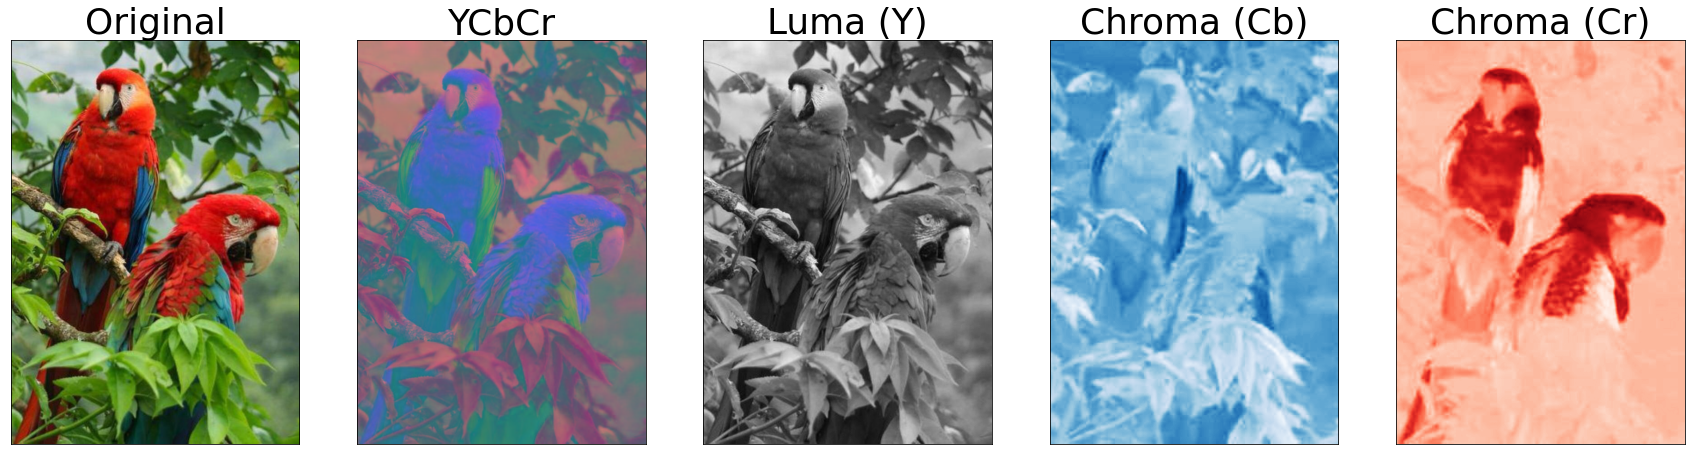

In [4]:
visualize([image, YCbCr_image, *np.dsplit(YCbCr_image, 3)],
          titles=['Original', 'YCbCr', 'Luma (Y)', 'Chroma (Cb)', 'Chroma (Cr)'],
          colormaps=[None, None, "gray", "Blues", "Reds"], scale=3)

### Шаг 2. Дискретное косинусное преобразование

После того, как каналы подготовлены, они делятся на непересекающиеся блоки размера 8x8 пикселей - последовательно слева направо 
и сверху вниз.
<br>
Если размеры канала не кратны 8, то канал дополняется - например, зеркалированием изображения через границу, или другими способами.

Итак, рассмотрим блок 8 на 8 пикселей. Напоминаю, что он уже разбит на яркостный и цветовые каналы, и преобразование проводится над каждым отдельно. Иными словами мы работаем уже с монохромными блоками.


In [5]:
def block_splitting(image):
    """
    params:
        image: Изображение, высота и ширина которого кратна 8
    
    yield:
        block: Непересекающиеся блоки размера 8x8 пикселей.
    """
    height, width = image.shape[0], image.shape[1]
    for x in range(0, height, 8):
        for y in range(0, width, 8):
            yield image[x:x+8, y:y+8]
            
def resize_image(image):
    """
    return: Изображение, высота и ширина которого кратна 8
    """
    height, width = image.shape[0], image.shape[1]

    if height % 8 != 0:
        height = height - (height%8)
        image = image[:height, :]
    if width % 8 != 0:
        width = width - (width%8)
        image = image[:, :width]
    return image

Y_channel = YCbCr_image[..., 1]
matrix = list(block_splitting(resize_image(Y_channel)))

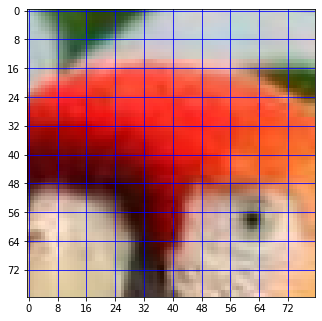

In [6]:
visualize_block_splitting(image[50: 50+8*10, 200: 200+8*10])


**Что ожидается от ДКП?**
<br>Алгоритм должен каким-то образом понять, насколько много деталей в каждом блоке. Например, если это монотонный кусок неба, его можно закодировать чуть ли не 1 байтом) А если это ваша невероятная прическа, там много переходов яркости и цвета, на это нужно потратить больше бит.
    
Ключевым компонентом работы алгоритма является дискретное косинусное преобразование. 
<br>Дискретное косинусное преобразование представляет собой разновидность преобразования Фурье и, так же как и оно, имеет обратное преобразование.
<br> Графическое изображение можно рассматривать как совокупность пространственных волн, причем оси X и Y совпадают с шириной и высотой картинки, а по оси Z откладывается значение цвета соответствующего пикселя изображения.

>Дискретное косинусное преобразование позволяет переходить от пространственного представления картинки к ее спектральному представлению и обратно.

![Following DCT kernel matrix:](https://user-images.githubusercontent.com/54672403/125614143-ab19602c-a2d9-4256-a88b-3df5f2de7424.jpg)

![Пространственные волны на сетке 8х8](https://user-images.githubusercontent.com/54672403/125611138-7d230795-9572-434c-86cb-7b5bb9f760a2.jpg)

Мы можем заметить, что в левом верхнем углу у нас находятся плавно меняющиеся изображения - это изображения, которые мы будем называть низкими частотами. А в правом нижнем углу находятся изображения, которые меняются очень быстро - это высокие частоты. И, наконец, в районе диагонали, соединяющей оставшиеся два угла, находятся какие-то промежуточные варианты - это средние частоты.

Есть другая версия отображения этих пространственных волн, трехмерная.

![Пространственные волны на сетке 8х8](https://user-images.githubusercontent.com/54672403/125611132-c6b3f488-17ef-49d2-9fda-c36f6d0b1c0f.jpg)


Воздействуя на спектральное представление картинки, состоящее из _гармоник_, то есть, отбрасывая наименее
значимые из них, можно балансировать между качеством воспроизведения и степенью сжатия.


Формулы прямого и обратного дискретного косинусного преобразования представлены ниже.

$$
\begin{gathered}
D C T[i, j]=\frac{1}{\sqrt{2 N}} C(i) C(j) \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} \operatorname{IDCT}[x, y] \cos \left[\frac{(2 x+1) i \pi}{2 N}\right] \cos \left[\frac{(2 y+1) i \pi}{2 N}\right] \\
C(x)=\left\{\begin{array}{l}
\frac{1}{\sqrt{2}}, x=0 \\
1, x>0
\end{array}\right.
\end{gathered}
$$
Формула обратного дискретного косинусного преобразования
$$
\operatorname{IDCT}[i, j]=\frac{1}{\sqrt{2 N}} \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} C(i) C(j) D C T[i, j] \cos \left[\frac{(2 x+1) i \pi}{2 N}\right] \cos \left[\frac{(2 y+1) i \pi}{2 N}\right]
$$
$$
C(x)=\left\{\begin{array}{l}
\frac{1}{\sqrt{2}}, x=0 \\
1, x>0
\end{array}\right.
$$

Visual test: Пространственные волны на сетке 8х8.



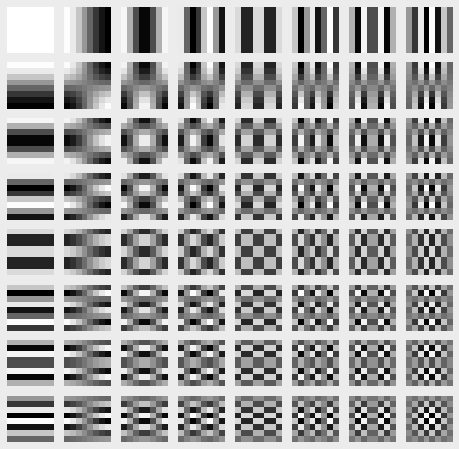

In [7]:
def get_DCT_kernel_matrix():
    dct = np.zeros((8, 8, 8, 8))
    for i in range(8):
        for j in range(8):
            for x in range(8):
                for y in range(8):
                    dct[i, j, x, y] = cos((2 * x + 1) * i * pi / 16) * cos((2 * y + 1) * j * pi / 16)
    return dct
          
print("Visual test: Пространственные волны на сетке 8х8.\n")
visualize_DCT_kernel_matrix(get_DCT_kernel_matrix())

In [8]:
def DCT(block):
    """
    params:
        block: Блок размера 8x8 пикселей
    return:
        dct_block: Матрица амплитуд (Блок размера 8x8 пикселей, с примененным к нему дискретно косинусным преобразованием.)
    """    
    # Нужно для центрирования значений блока вокруг нуля.    
    block = block - 128
    
    DCT_kernel = get_DCT_kernel_matrix()
    result = np.zeros((8, 8))
    C = lambda x: (1 / sqrt(2)) if x == 0 else 1
    for i in range(8):
        for j in range(8):
            dct_kernel_aij = 0
            for x in range(8):
                for y in range(8):
                    dct_kernel_aij += block[x, y] * DCT_kernel[i, j, x, y]
            result[i, j] = 0.25 * C(i) * C(j) * dct_kernel_aij
    return result

def scipy_DCT(block):
    """
    params:
        block: Блок размера 8x8 пикселей
    return:
        dct_block: Матрица амплитуд (Блок размера 8x8 пикселей, с примененным к нему дискретным косинусным преобразованием.)
    """
    block = block - 128
    dct_block = scipy.fft.dct(block, axis=0, type=2, norm="ortho")
    dct_block = scipy.fft.dct(dct_block, axis=1, type=2, norm="ortho")
    return dct_block

def inverse_dct(dct_block):
    """
    params:
        dct_block: Матрица амплитуд (Блок размера 8x8 пикселей, с примененным к нему дискретным косинусным преобразованием.)
    return:
        block: Блок размера 8x8 пикселей
    """
    block = scipy.fft.idct(dct_block, axis=0, type=2, norm="ortho")
    block = scipy.fft.idct(block, axis=1, type=2, norm="ortho")
    block = block + 128
    block = np.rint(block).astype(int)
    block = np.clip(block, 0, 255)
    return block

In [9]:
test_block = np.array([[52, 55, 61,  66,  70,  61, 64, 73],
                 [63, 59, 55,  90, 109,  85, 69, 72],
                 [62, 59, 68, 113, 144, 104, 66, 73],
                 [63, 58, 71, 122, 154, 106, 70, 69],
                 [67, 61, 68, 104, 126,  88, 68, 70],
                 [79, 65, 60,  70,  77,  68, 58, 75],
                 [85, 71, 64,  59,  55,  61, 65, 83],
                 [87, 79, 69,  68,  65,  76, 78, 94]])

dct_block = DCT(test_block)
print("Visual test: Матрица амплитуд.\n")
for row in dct_block:
    print(' '.join([str(round(s, 2)).rjust(7) for s in row]))

Visual test: Матрица амплитуд.

-415.37  -30.19   -61.2   27.24   56.12   -20.1   -2.39    0.46
   4.47  -21.86  -60.76   10.25   13.15   -7.09   -8.54    4.88
 -46.83    7.37   77.13  -24.56  -28.91    9.93    5.42   -5.65
 -48.53   12.07    34.1  -14.76  -10.24     6.3    1.83    1.95
  12.12   -6.55   -13.2   -3.95   -1.87    1.75   -2.79    3.14
  -7.73    2.91    2.38   -5.94   -2.38    0.94     4.3    1.85
  -1.03    0.18    0.42   -2.42   -0.88   -3.02    4.12   -0.66
  -0.17    0.14   -1.07   -4.19   -1.17    -0.1     0.5    1.68


**Как  происходит сжатие?**
<br>
Можно заметить, что в левом верхнем углу этой таблицы, т.е. при низких частотах, стоят большие по модулю коэффициенты, а в нижнем правом углу, т.е. при высоких частотах, стоят небольшие по модулю коэффициенты. Т.е. в данном блоке низкие частоты делают ощутимо больший вклад в формирование изображения, нежели высокие частоты.

Итак, высоких частот присутствует в изображении совсем немного. И алгоритм сжатия изображений JPEG основан на том, что низкие частоты сохраняются, а высокими частотами алгоритм пренебрегает (т.е. правый нижний треугольник таблицы - с высокими частотами - это часть, которая становится ненужной).

### Шаг 3 Квантование

После расчета DCT следующий шаг включает поиск и отбрасывание коэффициентов,
вклад которых в формирование изображения минимален.

Для решения этой задачи стандарт JPEG определяет простой механизм именуемый
квантованием. Чтобы выполнить квантование коэффициентов DCT, необходимо
разделить их на конкретное значение (_коэффициент квантования_) и округлить результат до ближайшего целого числа.

Можно также изменить качество сжатия, используя коэффициент квантования $Q \in [1, 100]$ и следующий алгоритм:

![ ](https://user-images.githubusercontent.com/54672403/125957380-4907280c-cf8b-4814-88e3-1a034bf1d4bb.png)


Чем больше коэффициент квантования, тем больше данных теряется, поскольку реальное DCT-значение представляется все менее и менее точно. 
Каждая из 64 позиций выходного блока DCT имеет собственный коэффициент квантования.
Причем термы большего порядка квантуются с большим коэффициентом, чем термы меньшего порядка. 
Кроме того, для данных яркости и цветности применяются отдельные таблицы квантования,
позволяющие квантовать данные цветности с большими коэффициентами, чем данные яркости.
Таким образом, JPEG использует различную чувствительность глаза к яркости и цветности изображения.

In [10]:
# Quantization matrix.
Q_MATRIX_Y = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72,  92, 95, 98, 112, 100, 103, 99]]
)

Q_MATRIX_CbCr = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])



In [11]:
def quantization(dct_block, quantization_matrix, q = 50):
    """
    return: Квантованные амплитуды.

    params:
        - dct_block: Матрица амплитуд (Блок размера 8x8 пикселей, с примененным к нему дискретным косинусным преобразованием.)
        - QMATRIX: Таблица квантования.
        - q: Kоэффициент квантования матрицы квантования в диапазоне [1, 100].
    """
    # Регулирование качество сжатия
    a = 5000 / q if q < 50 else 200 - 2 * q
    quantization_matrix = (a * quantization_matrix + 50) / 100
    quantization_matrix = np.floor(quantization_matrix)

    return np.round(dct_block / quantization_matrix).astype(np.int64)


def inverse_quantization(q_block, quantization_matrix, q = 50):
    """
    return:dct_block: Матрица амплитуд (Блок размера 8x8 пикселей, с примененным к нему дискретным косинусным преобразованием.)

    params:
        - q_block: Квантованные амплитуды.
        - QMATRIX: Таблица квантования.
        - q: Kоэффициент квантования матрицы квантования в диапазоне [1, 100].
    """
    # Регулирование качество сжатия
    a = 5000 / q if q < 50 else 200 - 2 * q
    
    quantization_matrix = np.floor((a * quantization_matrix + 50) / 100)
    return  np.multiply(q_block, quantization_matrix)

In [12]:
quant_block = quantization(dct_block, Q_MATRIX_CbCr, q=50)

print("Visual test: Матрица квантованных амплитуд.\n")
for row in quant_block:
    print(' '.join([str(s).rjust(3) for s in row]))

Visual test: Матрица квантованных амплитуд.

-24  -2  -3   1   1   0   0   0
  0  -1  -2   0   0   0   0   0
 -2   0   1   0   0   0   0   0
 -1   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0


Получилась таблица, большое количество элементов которой нулевые, и эти элементы соответствуют высоким частотам.
<br>
То есть при сжатии изображения мы в большей степени выкидываем высокие частоты, чем низкие.
Это происходит именно на данном этапе - этапе квантования.

### Шаг 4. Сжатие квантованных амплитуд


In [13]:
def zigzag(matrix):
    """
    Обход квадратной матрицы зигзагом.
    
    >>> matrix = [[1,2,6],
    ...          [3,5,7],
    ...          [4,8,9]]
    >>> zigzag(np.array(matrix))
    array([1, 3, 2, 6, 5, 4, 8, 7, 9])
    """
    columns, rows = len(matrix), len(matrix[0])
    diagonals = [[] for _ in range(columns + rows - 1)]

    for x in range(columns):
        for y in range(rows):
            sum_indexes = x + y
            if sum_indexes % 2 == 0:
                diagonals[sum_indexes].insert(0, matrix[x][y])
            else:
                diagonals[sum_indexes].append(matrix[x][y])
    flatten = []
    for zig in diagonals:
        flatten.extend(zig)
    return flatten


def inverse_zigzag(array):
    """
    Заполняет квадратную матрицу (8x8) зигзагом.
    
    >>> array = [1, 3, 2, 6, 5, 4, 8, 7, 9]
    >>> inverse_zigzag(array)
    """
    result = np.zeros((8, 8), dtype=int)
    diagonal = 0
    index = 0
    N = len(array)
    
    while index < N:
        for i, j in zip(range(diagonal + 1),  range(diagonal, -1, -1)):
            if index < N:
                if diagonal % 2 == 1:
                    result[i][j] = array[index]
                else: # flip
                    result[j][i] = array[index]
                index += 1
            else:
                break

        if diagonal < 7:
            diagonal += 1

    return result

In [14]:
zigzag_order = zigzag(quant_block)           
print('Visual test: Zig Zag Order')
print(*zigzag_order[:25], '...', zigzag_order[-5])

Visual test: Zig Zag Order
-24 -2 0 -2 -1 -3 1 -2 0 -1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 ... 0


Получаем одномерный массив с числами. Мы видим, что в нем много нулей, их можно убрать. Для этого вместо последовательности из множества нулей мы вписываем 1 нуль и после него число, обозначающее их количество в последовательности. Таким образом можно сбросить до 1/3 размера всего массива. А дальше просто сжимает этот массив методом Хаффмана и вписываем уже в сам файл.

In [15]:
def len_code_encoder(array):
    """
    >>>len_code_encoder([0, 1, 2, 3, 4, 5, 6, 0, 0, 0, 0, 0])
    [0, 1, 1, 2, 3, 4, 5, 6, 0, 5]
    """
    count = 0
    result = []
    for item in array:
        if item == 0:
            if count == 0:
                result.append(item)
            count += 1
        else:  # item != 0:
            if count != 0:
                result.append(count)
                count = 0
            result.append(item)
    if count != 0:
        result.append(count)
    return result


def len_code_decoder(array):
    
    """
    >>>len_code_decoder([0, 1, 1, 2, 3, 4, 5, 6, 0, 5])
    [0, 1, 2, 3, 4, 5, 6, 0, 0, 0, 0, 0]
    """
    result = []
    last_index = len(array)-1
    
    for i in range(len(array)):
        if array[i] == 0 and i != last_index:
            result += [0]*array[i+1]
        elif i != 0 and array[i-1] != 0:
            result.append(array[i])
        elif i == 0:
            result.append(array[i])
    return result

In [16]:
zigzag_encode = len_code_encoder(zigzag_order)        
print('Visual test: Len Code Encoder')
print(*zigzag_encode)

Visual test: Len Code Encoder
-24 -2 0 1 -2 -1 -3 1 -2 0 1 -1 0 2 1 0 1 1 0 49


#### Алгоритм Хаффмана

Коды или Алгоритм Хаффмана (_Huffman codes_) — широко распространенный и очень эффективный метод сжатия данных, который, в зависимости от характеристик этих данных, обычно позволяет сэкономить от 20% до 90% объема.
Рассматриваются данные, представляющие собой последовательность символов. В жадном алгоритме Хаффмана используется таблица, содержащая частоты появления тех или иных символов. С помощью этой таблицы определяется оптимальное представление каждого символа в виде бинарной строки.

>В основу алгоритма Хаффмана положена идея: кодировать более коротко те символы, которые встречаются чаще, а те, которые встречаются реже кодировать длиннее.

![huffnangif](https://user-images.githubusercontent.com/54672403/126045521-3bb6082f-fb1f-4ee9-a24f-60a0ee983be4.gif)


In [17]:
class TreeNode:
    def __init__(self, char, freq, left = None, right = None):
        self.char = char
        self.freq = freq 
        self.left = left
        self.right = right
        
    def __lt__(self, other):
        return self.freq < other.freq

    def __eq__(self, other):
        if (other == None):
            return False
        if (not isinstance(other, TreeNode)):
            return False
        return self.freq == other.freq
    
class HuffmanTree:
    """
    Usage:
        >>> h = HuffmanTree()
        >>> h.compress('AAAABBBBC')
        '\x02\x0f\xf8'
    """
    def __init__(self):
        self.heap = []
        self.root = None
        self.codes = {}
        self.reverse_mapping = {}
    
    def compress(self, text):
        frequency = self.get_frequency(text)
        self.make_heap(frequency)
        self.build_tree()
        self.make_codes()

        encoded_text = self.get_encoded_text(text)
        padded_encoded_text = self.pad_encoded_text(encoded_text)
        b = self.get_byte_array(padded_encoded_text)
        return b

    @staticmethod
    def get_frequency(data):
        """
        >>> get_frequency('ZZZZZZBBBA')
        [('Z', 6), ('B', 3), ('A', 1)]
        """
        return Counter(data).most_common()

    def make_heap(self, frequency):
        for item, freq in frequency:
            node = TreeNode(item, freq)
            heapq.heappush(self.heap, node)

    def build_tree(self):
        while (len(self.heap) > 1):
            node1 = heapq.heappop(self.heap)
            node2 = heapq.heappop(self.heap)

            # merged = TreeNode(node1.char + node2.char, node1.freq + node2.freq)
            merged = TreeNode(None, node1.freq + node2.freq)
            merged.left = node1
            merged.right = node2

            heapq.heappush(self.heap, merged)

    def huffman_tree_to_table(self, root, current_code):
        if (root == None):
            return

        if root.char != None:
            self.codes[root.char] = current_code
            self.reverse_mapping[current_code] = root.char
            return

        self.huffman_tree_to_table(root.left, current_code + "0")
        self.huffman_tree_to_table(root.right, current_code + "1")

    def make_codes(self):
        self.root = heapq.heappop(self.heap)
        current_code = ""
        self.huffman_tree_to_table(self.root, current_code)

    def get_encoded_text(self, text):
        encoded_text = ""
        for character in text:
            encoded_text += self.codes[character]
        return encoded_text

    @staticmethod
    def pad_encoded_text(encoded_text):
        """
        Return:  len of the added '0' + encoded text + added '0'
        
        Example:
             >>> pad_encoded_text('1011')
             '0000010010110000'
            # four in binary code| text | added four '0'
            #            00000100| 1011 | 0000
        """
        # if the length of the encode text is not divisible by 8 then pad with '0'
        extra_padding = 8 - len(encoded_text) % 8
        for i in range(extra_padding):
            encoded_text += "0"
        padded_info = "{0:08b}".format(extra_padding) # turn the len of the added chars to binary code (8 bit)
        encoded_text = padded_info + encoded_text
        return encoded_text

    @staticmethod
    def get_byte_array(padded_encoded_text):
        """
        Example:
            >>> get_byte_array('0000010010110000')        
            bytearray(b'\x04\xb0')
            #  first byte is 00000100 -   4 or \x04 
            # second byte is 10110000 - 176 or \xb0
        """
        b = bytearray()
        for i in range(0, len(padded_encoded_text), 8): # from 0 to n, iterate by 8 items
            byte = padded_encoded_text[i:i + 8]         # 1 byte = 8 bits
            b.append(int(byte, 2))                      # change a byte of base 2 into integer
        return b
    
    def format_print_huffman_table(self):
        print(tabulate.tabulate(self.codes.items(),
                                headers=['Char', 'Code'],
                                stralign='right',
                                tablefmt="github"))

|   Char |   Code |
|--------|--------|
|      A |      0 |
|      D |    100 |
|      C |    101 |
|      B |     11 |


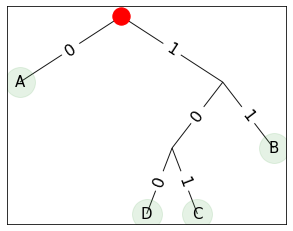

In [18]:
h = HuffmanTree()
result = h.compress('AAAAA'
                    'BBBB'
                    'CC'
                    'D')
                                     
visualize_huffman_tree(h, figsize=(5, 4))
h.format_print_huffman_table()

|   Char |   Code |
|--------|--------|
|    -24 |   0000 |
|     -3 |   0001 |
|      2 |   0010 |
|     49 |   0011 |
|      0 |     01 |
|     -1 |    100 |
|     -2 |    101 |
|      1 |     11 |


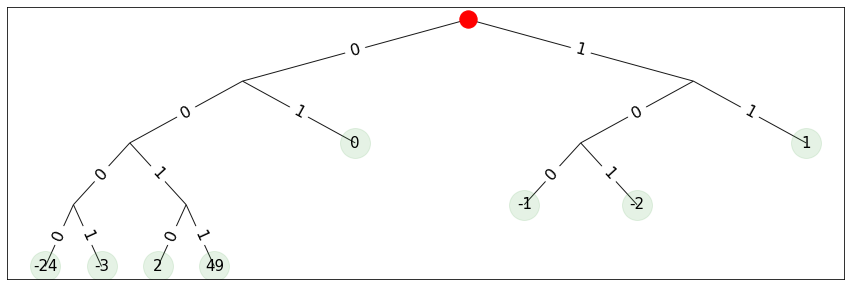

In [19]:
h = HuffmanTree()
result = h.compress(zigzag_encode)
                                     
visualize_huffman_tree(h)
h.format_print_huffman_table()


In [20]:
class HuffmanTreeDecoder():
    """
    Usage:
        >>> hd = HuffmanTreeDecoder({'0': 'A', '10': 'C', '11': 'B'})
        >>> hd.decompress('\x02\x0f\xf8')
        'AAAABBBBC'
    """
    def __init__(self, reverse_mapping: dict):
        self.reverse_mapping = reverse_mapping
        
    def remove_padding(self, padded_encoded_text):
        padded_info = padded_encoded_text[:8]
        extra_padding = int(padded_info, 2)

        padded_encoded_text = padded_encoded_text[8:]
        encoded_text = padded_encoded_text[:-1 * extra_padding]

        return encoded_text


    def decode_text(self, encoded_text):
        current_code = ""
        decoded = []
        
        for bit in encoded_text:
            current_code += bit
            if (current_code in self.reverse_mapping):
                character = self.reverse_mapping[current_code]
                decoded.append(character)
                current_code = ""
    
        return decoded


    def decompress(self, text):
        bit_string = ""
        
        for byte in text:
            #byte = ord(byte) FIXME: if byte is string
            bits = bin(byte)[2:].rjust(8, '0')
            bit_string += bits

        encoded_text = self.remove_padding(bit_string)
        decompressed = self.decode_text(encoded_text)
        return decompressed

In [21]:
hd = HuffmanTreeDecoder(h.reverse_mapping)
hd.decompress(result)

[-24, -2, 0, 1, -2, -1, -3, 1, -2, 0, 1, -1, 0, 2, 1, 0, 1, 1, 0, 49]

In [22]:
def jpeg_encoder(image, Q=50):
    """
    params:
        - image: image with channel mode RGB 
        - Q=50: quality factor of quantization matrix in range of [1, 100].
    
    """
    
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Input image dimension is not supported")
    
    image = resize_image(image)
    hufman_bitstream = []
    hufman_dictionaries = []
    YCbCr_image = RGB_to_YCbCr(image)
    
    for channel_index in range(3):
        
        
        channel = YCbCr_image[..., channel_index]

        # Step 1: Block splitting
        for block in block_splitting(channel):
            # Step 2: Discrete cosine transform (DCT)
            dct_block = scipy_DCT(block)
            
            # Step 3: Quantization + Round to nearest integer
            Q_MATRIX = Q_MATRIX_Y  if (channel_index == 0) else  Q_MATRIX_CbCr
            
            q_block = quantization(dct_block, Q_MATRIX, Q)
            
            # Step 4: Zigzag + len code encoder
            zigzag_order = zigzag(q_block)
            zigzag_encode = len_code_encoder(zigzag_order)
            
            # Step 5: Huffman tree
            h = HuffmanTree()
            final_encoding = h.compress(zigzag_encode)
            hufman_dictionaries.append(h.reverse_mapping)
            hufman_bitstream.append(final_encoding)

    return hufman_bitstream, hufman_dictionaries, image.shape[:2]

In [23]:
def jpeg_decoder(hufman_bitstream, hufman_dictionaries, height, width, Q=98):
    result_image = np.zeros((height, width, 3))
    
    # Step-1: Huffman Decoder
    decode_huffman=[]
    for i, hufman_dict in enumerate(hufman_dictionaries):
        hd = HuffmanTreeDecoder(hufman_dict)
        decode_huffman.append(hd.decompress(hufman_bitstream[i]))
    
    # Step-2: Len Code Decoder
    raw_blocks = map(len_code_decoder, decode_huffman)
    #raw_blocks = decode_huffman
    
    nb_blocks_in_row = height // 8
    nb_blocks_in_column = width // 8
    nb_blocks_in_channel = nb_blocks_in_row * nb_blocks_in_column
    
    row, col, channel = 0, 0, 0
    for nb_block, raw_block in enumerate(raw_blocks):
        # Step 3: Zigzag inverse.
        q_block  = inverse_zigzag(raw_block)
        
        # Step 4: Quantization inverse.
        Q_MATRIX = Q_MATRIX_Y  if (channel == 0) else  Q_MATRIX_CbCr
        dct_block = inverse_quantization(q_block, Q_MATRIX, Q) 

        # Step 5: DCT inverse.
        block = inverse_dct(dct_block)

        # Step 6: Block combination
        result_image[row:row+8, col:col+8, channel] = block
        
        col += 8

        # Go to next row.
        if ((nb_block + 1) % nb_blocks_in_column) == 0:
            row += 8
            col = 0

        # Go to next channel.
        if ((nb_block + 1) % nb_blocks_in_channel) == 0:
            channel += 1
            row, col = 0, 0
    return YCbCr_to_RGB(result_image)

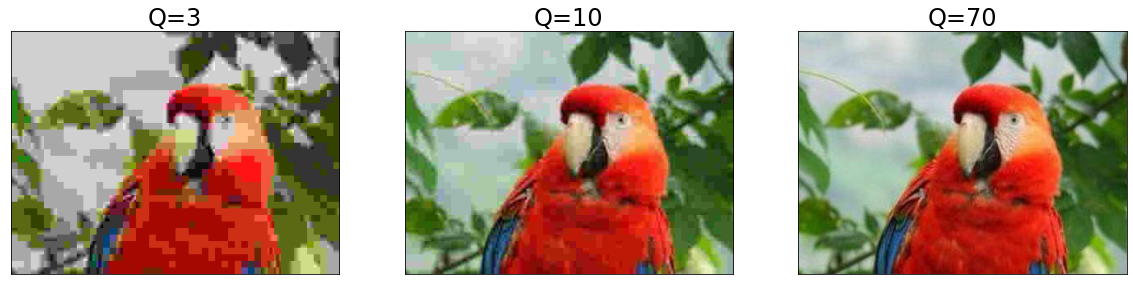

In [24]:
jpeg_images = []
for Q in [3, 10, 70]:
    hufman_bitstream, hufman_dictionaries, (height, width) = jpeg_encoder(image[:300, :400], Q)
    jpeg_image = jpeg_decoder(hufman_bitstream, hufman_dictionaries, height, width, Q)
    jpeg_images.append(jpeg_image)

visualize(jpeg_images, titles=['Q=3', 'Q=10', 'Q=70'], scale=2)

In [25]:
%load_ext line_profiler
r = %lprun -r -f jpeg_encoder \
hufman_bitstream, hufman_dictionaries, (height, width) = jpeg_encoder(image[:300, :400], Q=10)
r.print_stats()

Timer unit: 1e-07 s

Total time: 1.2919 s
File: <ipython-input-22-e7227ecfeaac>
Function: jpeg_encoder at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def jpeg_encoder(image, Q=50):
     2                                               """
     3                                               params:
     4                                                   - image: image with channel mode RGB 
     5                                                   - Q=50: quality factor of quantization matrix in range of [1, 100].
     6                                               
     7                                               """
     8                                               
     9         1         33.0     33.0      0.0      if len(image.shape) != 3 or image.shape[2] != 3:
    10                                                   raise ValueError("Input image dimension is not supported")
    11                

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Timer unit: 1e-07 s

Total time: 1.08578 s
File: <ipython-input-23-c088e6a77f20>
Function: jpeg_decoder at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def jpeg_decoder(hufman_bitstream, hufman_dictionaries, height, width, Q=98):
     2         1       1760.0   1760.0      0.0      result_image = np.zeros((height, width, 3))
     3                                               
     4                                               # Step-1: Huffman Decoder
     5         1         13.0     13.0      0.0      decode_huffman=[]
     6      5551      29281.0      5.3      0.3      for i, hufman_dict in enumerate(hufman_dictionaries):
     7      5550      49942.0      9.0      0.5          hd = HuffmanTreeDecoder(hufman_dict)
     8      5550     570903.0    102.9      5.3          decode_huffman.append(hd.decompress(hufman

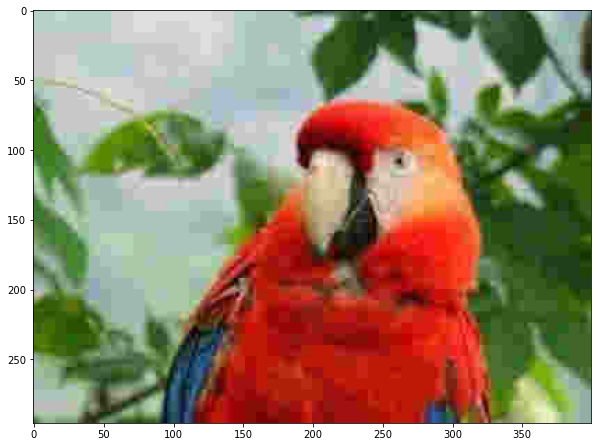

In [26]:
%load_ext line_profiler
r = %lprun -r -f jpeg_decoder \
jpeg_image = jpeg_decoder(hufman_bitstream, hufman_dictionaries, height, width, Q=10)
r.print_stats()


visualize(jpeg_image)

In [27]:
# Table A.4: JPEG Default DC code (luminance).
HUFFMAN_DC_TABLE = {
    0: "010",
    1: "011",
    2: "100",
    3: "00",
    4: "101",
    5: "110",
    6: "1110",
    7: "11110",
    8: "111110",
    9: "1111110",
    10: "11111110",
    11: "111111110"
}

# Table A.4: JPEG Default DC code (luminance).
HUFFMAN_DC_TABLE_INV = {
    "010": 0,
    "011": 1,
    "100": 2,
    "00": 3,
    "101": 4,
    "110": 5,
    "1110": 6,
    "11110": 7,
    "111110": 8,
    "1111110": 9,
    "11111110": 10,
    "111111110": 11
}

# Table A.5: JPEG default AC code (luminance)
HUFFMAN_AC_TABLE = {
    '0/0': "1010",
    '0/1': "00",
    '0/2': "01",
    '0/3': "100",
    '0/4': "1011",
    '0/5': "11010",
    '0/6': "111000",
    '0/7': "1111000",
    '0/8': "1111110110",
    '0/9': "1111111110000010",
    '0/10':"1111111110000011",
    '1/1': "1100",
    '1/2': "111001",
    '1/3': "1111001",
    '1/4': "111110110",
    '1/5': "11111110110",
    '1/6': "1111111110000100",
    '1/7': "1111111110000101",
    '1/8': "1111111110000110",
    '1/9': "1111111110000111",
    '1/10':"1111111110001000",
    '2/1': "11011",
    '2/2': "11111000",
    '2/3': "1111110111",
    '2/4': "1111111110001001",
    '2/5': "1111111110001010",
    '2/6': "1111111110001011",
    '2/7': "1111111110001100",
    '2/8': "1111111110001101",
    '2/9': "1111111110001110",
    '2/10':"1111111110001111",
    '3/1': "111010",
    '3/2': "111110111",
    '3/3': "11111110111",
    '3/4': "1111111110010000",
    '3/5': "1111111110010001",
    '3/6': "1111111110010010",
    '3/7': "1111111110010011",
    '3/8': "11111111110010100",
    '3/9': "11111111110010101",
    '3/10': "11111111110010110",
    '4/1': "111011",
    '4/2': "1111111000",
    '4/3': "1111111110010111",
    '4/4': "1111111110011000",
    '4/5': "1111111110011001",
    '4/6': "1111111110011010",
    '4/7': "1111111110011011",
    '4/8': "1111111110011100",
    '4/9': "1111111110011101",
    '4/10':"1111111110011110",
    '5/1': "1111010",
    '5/2': "1111111001",
    '5/3': "1111111110011111",
    '5/4': "1111111110100000",
    '5/5': "1111111110100001",
    '5/6': "1111111110100010",
    '5/7': "1111111110100011",
    '5/8': "1111111110100100",
    '5/9': "1111111110100101",
    '5/10':"1111111110100110" ,
    '6/1': "1111011",
    '6/2': "11111111000",
    '6/3': "1111111110100111",
    '6/4': "1111111110101000",
    '6/5': "1111111110101001",
    '6/6': "1111111110101010",
    '6/7': "1111111110101011",
    '6/8': "1111111110101100",
    '6/9': "1111111110101101",
    '6/10':"1111111110101110",
    '7/1': "11111001",
    '7/2': "11111111001",
    '7/3': "1111111110101111",
    '7/4': "1111111110110000",
    '7/5': "1111111110110001",
    '7/6': "1111111110110010",
    '7/7': "1111111110110011",
    '7/8': "1111111110110100",
    '7/9': "1111111110110101",
    '7/10':"1111111110110110",
    '8/1': "11111010",
    '8/2': "111111111000000",
    '8/3': "1111111110110111",
    '8/4': "1111111110111000",
    '8/5': "1111111110111001",
    '8/6': "1111111110111010",
    '8/7': "1111111110111011",
    '8/8': "1111111110111100",
    '8/9': "1111111110111101",
    '8/10':"1111111110111110",
    '9/1': "111111000",
    '9/2': "1111111110111111",
    '9/3': "1111111111000000",
    '9/4': "1111111111000001",
    '9/5': "1111111111000010",
    '9/6': "1111111111000011",
    '9/7': "1111111111000100",
    '9/8': "1111111111000101",
    '9/9': "1111111111000110",
    '9/10':"1111111111000111",
    '10/1':"111111001",
    '10/2':"1111111111001000",
    '10/3':"1111111111001001",
    '10/4':"1111111111001010",
    '10/5':"1111111111001011",
    '10/6':"1111111111001100",
    '10/7':"1111111111001101",
    '10/8':"1111111111001110",
    '10/9':"1111111111001111",
    '10/10':"1111111111010000",
    '11/1':"111111010",
    '11/2':"1111111111010001",
    '11/3':"1111111111010010",
    '11/4':"1111111111010011",
    '11/5':"1111111111010100",
    '11/6':"1111111111010101",
    '11/7':"1111111111010110",
    '11/8':"1111111111010111",
    '11/9':"1111111111011000",
    '11/10':"1111111111011001",
    '12/1':"1111111010",
    '12/2':"1111111111011010",
    '12/3':"1111111111011011",
    '12/4':"1111111111011100",
    '12/5':"1111111111011101",
    '12/6':"1111111111011110",
    '12/7':"1111111111011111",
    '12/8':"1111111111100000",
    '12/9':"1111111111100001",
    '12/10':"1111111111100010",
    '13/1':"11111111010",
    '13/2':"1111111111100011",
    '13/3':"1111111111100100",
    '13/4':"1111111111100101",
    '13/5':"1111111111100110",
    '13/6':"1111111111100111",
    '13/7':"1111111111101000",
    '13/8':"1111111111101001",
    '13/9':"1111111111101010",
    '13/10':"1111111111101011",
    '14/1':"111111110110",
    '14/2':"1111111111101100",
    '14/3':"1111111111101101",
    '14/4':"1111111111101110",
    '14/5':"1111111111101111",
    '14/6':"1111111111110000",
    '14/7':"1111111111110001",
    '14/8':"1111111111110010",
    '14/9':"1111111111110011",
    '14/10':"1111111111110100",
    '15/0':"111111110111",
    '15/1':"1111111111110101",
    '15/2':"1111111111110110",
    '15/3':"1111111111110111",
    '15/4':"1111111111111000",
    '15/5':"1111111111111001",
    '15/6':"1111111111111010",
    '15/7':"1111111111111011",
    '15/8':"1111111111111100",
    '15/9':"1111111111111101",
    '15/10':"1111111111111110"
}


# Table A.5: JPEG default AC code (luminance)

HUFFMAN_AC_TABLE_INV = {
    "1010": "0/0",
    "00": "0/1",
    "01": "0/2",
    "100": "0/3",
    "1011": "0/4",
    "11010": "0/5",
    "111000": "0/6",
    "1111000": "0/7",
    "1111110110": "0/8",
    "1111111110000010": "0/9",
    "1111111110000011": "0/10",
    "1100": "1/1",
    "111001": "1/2",
    "1111001": "1/3",
    "111110110": "1/4",
    "11111110110": "1/5",
    "1111111110000100": "1/6",
    "1111111110000101": "1/7",
    "1111111110000110": "1/8",
    "1111111110000111": "1/9",
    "1111111110001000": "1/10",
    "11011": "2/1",
    "11111000": "2/2",
    "1111110111": "2/3",
    "1111111110001001": "2/4",
    "1111111110001010": "2/5",
    "1111111110001011": "2/6",
    "1111111110001100": "2/7",
    "1111111110001101": "2/8",
    "1111111110001110": "2/9",
    "1111111110001111": "2/10",
    "111010": "3/1",
    "111110111": "3/2",
    "11111110111": "3/3",
    "1111111110010000": "3/4",
    "1111111110010001": "3/5",
    "1111111110010010": "3/6",
    "1111111110010011": "3/7",
    "11111111110010100": "3/8",
    "11111111110010101": "3/9",
    "11111111110010110": "3/10",
    "111011": "4/1",
    "1111111000": "4/2",
    "1111111110010111": "4/3",
    "1111111110011000": "4/4",
    "1111111110011001": "4/5",
    "1111111110011010": "4/6",
    "1111111110011011": "4/7",
    "1111111110011100": "4/8",
    "1111111110011101": "4/9",
    "1111111110011110": "4/10",
    "1111010": "5/1",
    "1111111001": "5/2",
    "1111111110011111": "5/3",
    "1111111110100000": "5/4",
    "1111111110100001": "5/5",
    "1111111110100010": "5/6",
    "1111111110100011": "5/7",
    "1111111110100100": "5/8",
    "1111111110100101": "5/9",
    "1111111110100110": "5/10",
    "1111011": "6/1",
    "11111111000": "6/2",
    "1111111110100111": "6/3",
    "1111111110101000": "6/4",
    "1111111110101001": "6/5",
    "1111111110101010": "6/6",
    "1111111110101011": "6/7",
    "1111111110101100": "6/8",
    "1111111110101101": "6/9",
    "1111111110101110": "6/10",
    "11111001": "7/1",
    "11111111001": "7/2",
    "1111111110101111": "7/3",
    "1111111110110000": "7/4",
    "1111111110110001": "7/5",
    "1111111110110010": "7/6",
    "1111111110110011": "7/7",
    "1111111110110100": "7/8",
    "1111111110110101": "7/9",
    "1111111110110110": "7/10",
    "11111010": "8/1",
    "111111111000000": "8/2",
    "1111111110110111": "8/3",
    "1111111110111000": "8/4",
    "1111111110111001": "8/5",
    "1111111110111010": "8/6",
    "1111111110111011": "8/7",
    "1111111110111100": "8/8",
    "1111111110111101": "8/9",
    "1111111110111110": "8/10",
    "111111000": "9/1",
    "1111111110111111": "9/2",
    "1111111111000000": "9/3",
    "1111111111000001": "9/4",
    "1111111111000010": "9/5",
    "1111111111000011": "9/6",
    "1111111111000100": "9/7",
    "1111111111000101": "9/8",
    "1111111111000110": "9/9",
    "1111111111000111": "9/10",
    "111111001": "10/1",
    "1111111111001000": "10/2",
    "1111111111001001": "10/3",
    "1111111111001010": "10/4",
    "1111111111001011": "10/5",
    "1111111111001100": "10/6",
    "1111111111001101": "10/7",
    "1111111111001110": "10/8",
    "1111111111001111": "10/9",
    "1111111111010000": "10/10",
    "111111010": "11/1",
    "1111111111010001": "11/2",
    "1111111111010010": "11/3",
    "1111111111010011": "11/4",
    "1111111111010100": "11/5",
    "1111111111010101": "11/6",
    "1111111111010110": "11/7",
    "1111111111010111": "11/8",
    "1111111111011000": "11/9",
    "1111111111011001": "11/10",
    "1111111010": "12/1",
    "1111111111011010": "12/2",
    "1111111111011011": "12/3",
    "1111111111011100": "12/4",
    "1111111111011101": "12/5",
    "1111111111011110": "12/6",
    "1111111111011111": "12/7",
    "1111111111100000": "12/8",
    "1111111111100001": "12/9",
    "1111111111100010": "12/10",
    "11111111010": "13/1",
    "1111111111100011": "13/2",
    "1111111111100100": "13/3",
    "1111111111100101": "13/4",
    "1111111111100110": "13/5",
    "1111111111100111": "13/6",
    "1111111111101000": "13/7",
    "1111111111101001": "13/8",
    "1111111111101010": "13/9",
    "1111111111101011": "13/10",
    "111111110110": "14/1",
    "1111111111101100": "14/2",
    "1111111111101101": "14/3",
    "1111111111101110": "14/4",
    "1111111111101111": "14/5",
    "1111111111110000": "14/6",
    "1111111111110001": "14/7",
    "1111111111110010": "14/8",
    "1111111111110011": "14/9",
    "1111111111110100": "14/10",
    "111111110111": "15/0",
    "1111111111110101": "15/1",
    "1111111111110110": "15/2",
    "1111111111110111": "15/3",
    "1111111111111000": "15/4",
    "1111111111111001": "15/5",
    "1111111111111010": "15/6",
    "1111111111111011": "15/7",
    "1111111111111100": "15/8",
    "1111111111111101": "15/9",
    "1111111111111110": "15/10"
}

# Table A.3: JPEG coefficient coding categories. Only category range 15.
LARGEST_RANGE = list(itertools.product(['0', '1'], repeat=15))

In [28]:
def decimal_to_binary(x):
    """
    Returns binary representation from decimal representation given a category range.
    params:
    - x: integer from the range [-32767, -16384] ∩ [16384, 32767].
    - LARGEST_RANGE: JPEG coefficient coding categories. Only category range 15.
    note:
    - Only LARGEST_RANGE category 15 is pre-computed. We can then retrieve all category range from it.

    example:
        `x = 3` is in category 2:
        binary:  00  01  10  11
        range :  -3  -2   2   3
        Its binary representation is `11`.
    """
    if x == 0:
        return 0, "0"

    category = len(bin(x).partition('b')[-1])
    subset = LARGEST_RANGE[0:2**category]
    mid = len(subset) // 2
    val = subset[:mid][(x % mid) - 1] if (x < 0) else subset[mid:][x - mid]
    return category, "".join(val)[-category:]

def binary_to_decimal(binary):
    """
    Returns decimal representation from binary representation given a category range.
    params:
    - binary: binary number from the range [-32767, -16384] ∩ [16384, 32767].
    - LARGEST_RANGE: JPEG coefficient coding categories. Only category range 15.
    note:
    - Only LARGEST_RANGE category 15 is pre-computed. We can then retrieve all category range from it.

    example:
        `binary = 11` is in category 2:
        binary:  00  01  10  11
        range :  -3  -2   2   3
        Its decimal representation is `3`.
    """
    CAT = len(binary)
    subset = LARGEST_RANGE[0:2**CAT]
    n = len(subset)
    mid, left = n // 2, n - 1

    for inc_right, elt in enumerate(subset):
        tmp = "".join(elt[-CAT:])
        if binary == tmp:
            return -left + inc_right if (inc_right < mid) else inc_right
    return 0

def huffman(zigzag_order):
    """
    returns encoded macroblock from zigzag ordering.
    params:
        - zigzag_order: zigzag ordering of quantized block.
        - LARGEST_RANGE: JPEG coefficient coding categories. Only category range 15.
    """
    
    final_encoding = []

    # DC coeff encoding    
    dc_coeff = zigzag_order[0] if len(zigzag_order) > 0 else 0
    CAT, binary = decimal_to_binary(dc_coeff)
    codeword = HUFFMAN_DC_TABLE[CAT]
    final_encoding.append(codeword + binary)

    # AC coeff encoding: Run Length Encoding
    RUN = 0
    for ac_coeff in zigzag_order[1:]:
        if ac_coeff == 0:
            RUN += 1
            continue
        
        while RUN - 15 > 0:
            # Split in batch of "15/0".
            codeword = HUFFMAN_AC_TABLE["15/0"]
            final_encoding.append(codeword + "0")
            RUN -= 15
        
        CAT, binary = decimal_to_binary(ac_coeff)
        codeword = HUFFMAN_AC_TABLE[f"{RUN}/{CAT}"]
        final_encoding.append(codeword + binary)
        RUN = 0
    
    # Add end of block.
    EOB = "0/0"
    final_encoding.append(HUFFMAN_AC_TABLE[EOB])
    return final_encoding

huffman([1,2,3,4,5])

['0111', '0110', '0111', '100100', '100101', '1010']

In [29]:
def huffman_inv(bitstream, beg=0, end=0):
    """
    Yield macroblock in zigzag order from input bistream.
    params:
    - bitstream: string representing compressed image.
    - LARGEST_RANGE: JPEG coefficient coding categories. Only category range 15.
    """
    while end < len(bitstream):
        final_encoding, beg, end = huffman_inv_aux(bitstream, beg, end)
        yield final_encoding   

def huffman_inv_aux(bitstream, beg, end):
    """
    Returns macroblock in zigzag order from input bistream.
    params:
    - bitstream: string representing compressed image.
    - LARGEST_RANGE: JPEG coefficient coding categories. Only category range 15.
    """
    zigzag_order = []

    # Retrieve DC coeff
    while end < len(bitstream):
        codeword = bitstream[beg:end]
        if codeword in HUFFMAN_DC_TABLE_INV:
            CAT = HUFFMAN_DC_TABLE_INV[codeword]
            break
        end += 1

    dc_coeff = binary_to_decimal(bitstream[end: end + CAT])
    zigzag_order.append(dc_coeff)
    
    end += max(CAT, 1)
    beg = end

    EOB = "1010"

    while end < len(bitstream):
        # Retrieve AC coeff
        codeword = bitstream[beg:end]
        while (codeword not in HUFFMAN_AC_TABLE_INV):
            end += 1
            codeword = bitstream[beg:end]

        if codeword == EOB:
            beg = end
            break

        RUN_CAT = HUFFMAN_AC_TABLE_INV[codeword]
        RUN, CAT = RUN_CAT.split("/")
        RUN, CAT = int(RUN), int(CAT)

        ac_coeff = binary_to_decimal(bitstream[end: end + CAT])

        for i in range(RUN):
            zigzag_order.append(0)
            
        zigzag_order.append(ac_coeff)

        end += max(CAT, 1)
        beg = end

    return zigzag_order, beg, end


In [30]:
[zigzag_order for zigzag_order in huffman_inv('0111011001111001001001011010')]

[[1, 2, 3, 4, 5]]

In [31]:
def jpeg_encoder(image, Q=50):
    """
    params:
        - image: image with channel mode RGB 
        - Q=50: quality factor of quantization matrix in range of [1, 100].
    
    """
    
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Input image dimension is not supported")
    
    image = resize_image(image)
    hufman_bitstream = []
    YCbCr_image = RGB_to_YCbCr(image)
    
    for channel_index in range(3):
        channel = YCbCr_image[..., channel_index]

        # Step 1: Block splitting
        for block in block_splitting(channel):
            # Step 2: Discrete cosine transform (DCT)
            dct_block = scipy_DCT(block)
            
            # Step 3: Quantization + Round to nearest integer
            Q_MATRIX = Q_MATRIX_Y  if (channel_index == 0) else  Q_MATRIX_CbCr
            
            q_block = quantization(dct_block, Q_MATRIX, Q)
            
            # Step 4: Zigzag + len code encoder
            zigzag_order = zigzag(q_block)
            
            # Step 5: Huffman tree
            final_encoding = huffman(zigzag_order)
            hufman_bitstream.append(final_encoding)

    out = "".join(map(str, np.concatenate(hufman_bitstream)))
    return out, image.shape[:2]

In [39]:
def jpeg_decoder(hufman_bitstream, height, width, Q=98):
    result_image = np.zeros((height, width, 3))
    
    nb_blocks_in_row = height // 8
    nb_blocks_in_column = width // 8
    nb_blocks_in_channel = nb_blocks_in_row * nb_blocks_in_column
    
    row, col, channel = 0, 0, 0    
    for nb_block, raw_block in enumerate(huffman_inv(hufman_bitstream)): 
        # Step-1: Huffman Decoder
        # Step 2: Zigzag inverse.
        q_block  = inverse_zigzag(raw_block)
        
        # Step 3: Quantization inverse.
        Q_MATRIX = Q_MATRIX_Y  if (channel == 0) else  Q_MATRIX_CbCr
        dct_block = inverse_quantization(q_block, Q_MATRIX, Q) 

        # Step 4: DCT inverse.
        block = inverse_dct(dct_block)

        # Step 5: Block combination
        result_image[row:row+8, col:col+8, channel] = block
        
        col += 8

        # Go to next row.
        if ((nb_block + 1) % nb_blocks_in_column) == 0:
            row += 8
            col = 0

        # Go to next channel.
        if ((nb_block + 1) % nb_blocks_in_channel) == 0:
            channel += 1
            row, col = 0, 0
    return YCbCr_to_RGB(result_image)

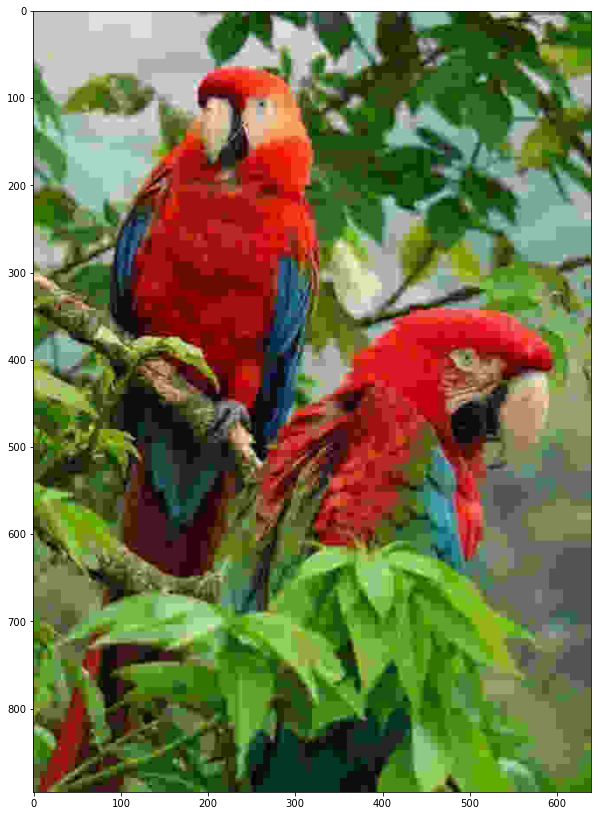

In [40]:
hufman_bitstream, (height, width) = jpeg_encoder(image, Q=5)
jpeg=jpeg_decoder(hufman_bitstream, height, width, 5)
visualize(jpeg)